# Lesson 6: Collaborative Filtering

This notebook will cover collaborative filtering using the [MovieLens](https://grouplens.org/datasets/movielens/100k/) data set.



In [1]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

### Data

"MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.


This data set consists of:

* 100,000 ratings (1-5) from 943 users on 1682 movies. 
* Each user has rated at least 20 movies. 
* Simple demographic info for the users (age, gender, occupation, zip)"


**Additional Info**

- `u.data` contains the full data set, 100,000 ratings by 943 users on 1,682 items. 
- Each user has rated at least 20 movies.  
- Users and items are numbered consecutively from 1.  
- The data is randomly ordered. 
- This is a tab separated list of 
    - `user id` | `item id` | `rating` | `timestamp` 
    - The time stamps are unix seconds since 1/1/1970 UTC   
    
    
[source](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt)

In [2]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


The goal is to predict or guess what films users might like to watch. You could easily imagine that a user might have a preference for certain genres, and based on films they have seen from a particular genre, you might be able to say something like, user `123` likes `action` movies, therefore it would be safe to suggest an action movie to them. 

Given that we have minimal information in our data set (userid, movieid, rating and timestamp), collaborative filter seeks to solve this problem by extracting latent features from the data. 

For example, assume that these features range between -1 and +1, with postive numbers indicating stronger mathes to certain factors. 

We can use a simple example to illustrate the point. Take the following three dummy factors `science-fiction`, `action`, and `old movies`, we can compare user preferences against these for two different movies and see how they score.

In [2]:
import numpy as np

last_skywalker = np.array([0.98,0.9,-0.9])
casablanca = np.array([-0.99,-0.3,0.8])

user1 = np.array([0.9,0.8,-0.6])

We can compute the dot product and arrive at a match

In [4]:
m1 = (user1*last_skywalker).sum()
m2 = (user1*casablanca).sum()

print(f'last skywalker match: {m1.round(2)} \n casablanca match: {m2.round(2)}')

last skywalker match: 2.14 
 casablanca match: -1.61


Voila! based on this we might want to recommend Last Skywalker but not Casablanca to this user. 

So how do we find these latent factors? They can be learned.

### Step 1: Randomly Initialize Parameters 
Randomly assign parameters to represent our latent factors for each user and each movie. We get to decide how many of these factors we want to use.  

### Step 2: Calculate Predictions
Calculate predictions. This is done as we have just seen, by computing the dot product. 

### Step 3: Improve Predictions
Then improve the prediction using gradient descent on these latent factors


First, let's add the movie titles to our data set for readability

In [5]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
# join on movie titles
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


### Create a DataLoader

In [7]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,494,"Shawshank Redemption, The (1994)",5
1,806,"Wrong Trousers, The (1993)",5
2,91,Glory (1989),5
3,497,Lawnmower Man 2: Beyond Cyberspace (1996),2
4,630,"Rainmaker, The (1997)",3
5,89,That Thing You Do! (1996),2
6,442,"Brothers McMullen, The (1995)",3
7,37,Braveheart (1995),5
8,159,Kansas City (1996),1
9,585,Cinema Paradiso (1988),5


In [9]:
dls.classes

{'user': (#944) ['#na#',1,2,3,4,5,6,7,8,9...],
 'title': (#1665) ['#na#',"'Til There Was You (1997)",'1-900 (1994)','101 Dalmatians (1996)','12 Angry Men (1957)','187 (1997)','2 Days in the Valley (1996)','20,000 Leagues Under the Sea (1954)','2001: A Space Odyssey (1968)','3 Ninjas: High Noon At Mega Mountain (1998)'...]}

### Randomly initialize parameters

- create `user_factors` and `movie_factors` of size n users x n factors and n movies by n factors

In [8]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

user_factors.size()

torch.Size([944, 5])

### One Hot Encoding

We need to prepare our data in a specific way before we can pass it to our model. Some algorithms can work directly with category labels, but many cannot. 

One hot encoding is a way of representing categorical data by transforming categorical labels into vectors of 0s and 1s. 

To get a sense of how one-hot-encoding is operating, here is a simple example...

In [9]:
df = pd.DataFrame(['adam', 'beatrix', 'cam'])

df

,0
0,adam
1,beatrix
2,cam


In [10]:
# the categorical variables are represented by 1s and 0s
pd.get_dummies(df)

,0_adam,0_beatrix,0_cam
0,1,0,0
1,0,1,0
2,0,0,1


In order to calculate a result for a particular user and movie combination, we weill need to look up the index of the movie, and the index of a user in the respective latent factor matrices, then perform a dot product. 

But this is not something that our model is capable of doing. It is capable of performing dot products though.. 

Here is another example of how we can use dot products to return elements from a matrix...

say the rows in matrix `w` represent latent movie factors and the matrix `v` is our one hot encoded movie ids

In [148]:
w = torch.randn((3,3))
w

tensor([[-1.7224, -0.4789,  0.3553],
        [-1.3465, -0.3057,  0.6882],
        [ 0.4594,  0.7893,  0.0150]])

In [165]:
v = torch.tensor([[1,0,0],[0,1,0],[0,0,1]])
v

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])

we can retrieve the factors for movie 2 (row 2 of `w`) by preforming a matrix product on the corresponding row of `v`

In [164]:
v[1].float() @ w

tensor([-1.3465, -0.3057,  0.6882])

this is the same as calling..

In [166]:
w[1]

tensor([-1.3465, -0.3057,  0.6882])

One hot encoding is basically performing an index lookup on our data. This is however memory intensive since we now have these huge matrices to deal with and most of the values will be 0. 

Enter **embeddings**. Embeddings are a computational shortcut for doing matrix multiplication of one-hot-encoded vectors 

I found [this](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) link useful

## Collaborative filtering from Scratch

`forward` is a very important method name in PyTorch. `forward` will be the method that handles computation.


### `DotProduct`

The `forward` method here will get passed users and movies in two column (`x`). We then grab the factors from an embedding by calling `user_factors` just like a function. Assign these to `users` and `movies` then perform the dot product using `(users * movies).sum(dim=1)`. `dim=1` is used because we want to sum over the second index

```python
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
    
    def forward(self, x):
        
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)
```    

In [11]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [12]:
x,y = dls.one_batch()

# check the shape of x
x.shape

torch.Size([64, 2])

In [13]:
# check the first 5 things in x
x[:5]

# user ids and movie ids

tensor([[ 396, 1021],
        [ 118,  887],
        [ 206,  380],
        [ 207,  938],
        [ 923,  861]], device='cuda:0')

What does `torch.Size([64, 2])` tell us?
- batch size is 64
- then we have 2 items, the user ids and movie ids
    - check with `x[:,0]` and `x[:,1]`

In [14]:
# check the first 5 things of 7
y[:5]

# these are the ratings

tensor([[4],
        [5],
        [1],
        [3],
        [4]], device='cuda:0', dtype=torch.int8)

### Create a learner
- our model will be the `DotProduct` class with 50 latent factors
- loss function will be MSE
    - this is a regression problem for continuous variables

In [46]:
model = DotProduct(n_users, n_movies, n_factors=50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [47]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.362978,1.286954,00:08
1,1.051144,1.094442,00:08
2,0.963542,0.975438,00:08
3,0.841074,0.893598,00:08
4,0.788252,0.873474,00:08


Not bad but we can make some improvements. We can use a `sigmoid` to contrain our ratings between 0 and 5, matching what we see in our original data set. We will actually use 0-5.5 otherwise the sigmoid will prevent us ever getting a 5.

In [49]:
# check rating scores/categories
ratings.rating.value_counts()

4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64

In [54]:
help(sigmoid_range)

Help on function sigmoid_range in module fastai.layers:

sigmoid_range(x, low, high)
    Sigmoid function with range `(low, high)`



In [15]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [53]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.024472,0.989683,00:08
1,0.882552,0.901929,00:08
2,0.684762,0.860367,00:08
3,0.479302,0.864543,00:08
4,0.347512,0.870277,00:08


Not much better....

### Adding in a Bias term

We can make further improvements by adding a bias term to our model. 

Why would we do this? Some movies may have a high rating because they are genuinely better movies, and some users may skew towards being more positive and therefore their rating could generally be more positive. The idea of the bias term is that we now have a way to represent this missing piece of information. 

In [16]:
# Add in a bias term for each user and each movie. 

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [56]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.969996,0.988517,00:08
1,0.900296,0.907242,00:08
2,0.691395,0.859838,00:08
3,0.491507,0.861104,00:08
4,0.365541,0.864733,00:08


Our final result is slightly better but we are actually overfitting! How can we stop this and train for longer?

## Regularisation

Regularisation is a set of techniques that help to reduce the capacity of the model. Regularisations helps to prevent overfitting of models. Rather than reduce the parameters, we can try to force the parameters to be smaller, unless they are required to be big. 


### Weight Decay

Also known as L2 regularisation. It consists of adding to the loss function the sum of all the parameters squared. 

Why does this work and why would this prevent overfitting? 
- one way to decrease loss is to decrease the weights
- limiting the weights is going to hinder the training (won't fit training set as well) but will help the model to generalise better

In practice what we are doing is adding onto the gradients, the weights multiplied by some hyper parameter.

In [17]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.953578,0.935531,00:08
1,0.846484,0.874122,00:07
2,0.718206,0.829690,00:07
3,0.593549,0.817133,00:07
4,0.474108,0.818135,00:08


much better!

## Creating our own Embedding module

Let's recreate the `DotProductBias` without using the Embedding class.

to recap:
- an embedding layer is a computational shortcut for performing a matrix multiplication by a one hot encoded matrix, which is the same as indexing into an array.



In [19]:
# create a tensor as a parameter, with random initialization

def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

The below is `DotProductBias` refactored

In [20]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [21]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.958299,0.949737,00:08
1,0.890685,0.870207,00:08
2,0.742867,0.825684,00:08
3,0.575261,0.817917,00:08
4,0.467277,0.818017,00:09


## Interpreting Embeddings and Biases

Let's take a look at some of the films with the smallest bias. These would be movies that were liked a lot less than others. 

We can then do the opposite to see the most liked movies (sorting by bias)

The goal is to see what the model has learnt and to gain some information about how it is operating. 

Then using PCA we can reduce the number of latent factors and plot these to view the "space". Again, this is a way we can interpret what the model has learnt.

In [22]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Robocop 3 (1993)',
 'Leave It to Beaver (1997)',
 'Vampire in Brooklyn (1995)']

In [23]:
# most liked films
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 "Schindler's List (1993)",
 'As Good As It Gets (1997)',
 'L.A. Confidential (1997)',
 'Apt Pupil (1998)']

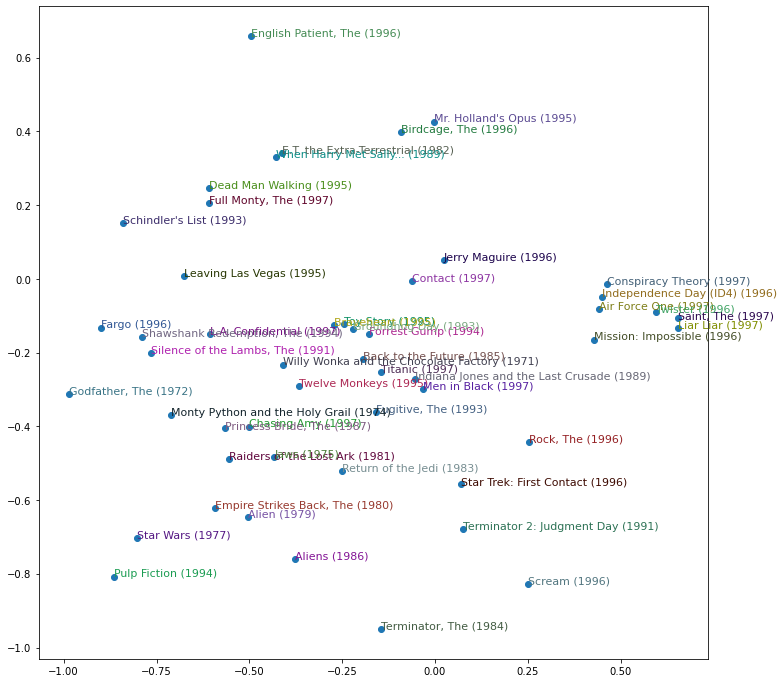

In [24]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

The most interesting cluster I can see is on the mid-right hand side. Conspiracy Theory, Mission Impossible, Air Force One etc. Asside from Liar Liar, these seem like the kinds of movies that someone who likes action films would likely enjoy. 

### The fastai way

In [25]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [26]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.941142,0.945376,00:08
1,0.861970,0.873035,00:08
2,0.724418,0.828043,00:08
3,0.617956,0.815366,00:08
4,0.488715,0.815252,00:08


### Summary

We have just implemented a simple collaborative filtering model from scratch. The idea with this lesson, as with most of them so far, is to dig into the theory, code a model from scratch (mostly), improve the mode, then use the fastai implementation. 